In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [3]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

TRASHNET_DIR = r"D:\Celestia\Projects\Personal_Projects\material_recy\data\dataset-resized\dataset-resized"
ROBOFLOW_DIR = r"D:\Celestia\Projects\Personal_Projects\material_recy\data\GARBAGE CLASSIFICATION.tensorflow"

IMG_SIZE = 128
CHUNK_SIZE = 5000  

CATEGORIES = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

In [130]:
def load_and_resize_image(img_path, img_size):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None or img.size == 0:
            raise ValueError(f"Empty or invalid image at {img_path}")
        return cv2.resize(img, (img_size, img_size))
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None


In [131]:
def load_trashnet_data():
    images, labels = [], []
    for category in CATEGORIES:
        folder = os.path.join(TRASHNET_DIR, category)
        class_num = CATEGORIES.index(category)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = load_and_resize_image(img_path, IMG_SIZE)
            if img is not None:
                images.append(img)
                labels.append(class_num)
    return images, labels

In [132]:
def load_roboflow_data(split):
    images, labels = [], []
    folder = os.path.join(ROBOFLOW_DIR, split)
    annotations_file = os.path.join(folder, "_annotations.csv")
    annotations = pd.read_csv(annotations_file)

    normalized_categories = [category.lower() for category in CATEGORIES]

    for _, row in annotations.iterrows():
        img_name = row['filename']
        label = row['class'].lower()  # Normalize label

        if label == "biodegradable":
            label = "trash"  # Map biodegradable to trash

        if label in normalized_categories:
            img_path = os.path.join(folder, img_name)
            img = load_and_resize_image(img_path, IMG_SIZE)
            if img is not None:
                images.append(img)
                labels.append(normalized_categories.index(label))
    return images, labels

In [133]:
def process_images_in_chunks(images, labels, img_size, chunk_size):
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for i in range(0, len(images), chunk_size):
        chunk_images = images[i:i + chunk_size]
        chunk_labels = labels[i:i + chunk_size]

        resized_images = np.array(chunk_images, dtype='float32') / 255.0  # Normalize and convert to float32
        resized_labels = np.array(chunk_labels)

        X_train_chunk, X_test_chunk, y_train_chunk, y_test_chunk = train_test_split(
            resized_images, resized_labels, test_size=0.2, random_state=42
        )

        X_train_list.append(X_train_chunk)
        X_test_list.append(X_test_chunk)
        y_train_list.append(y_train_chunk)
        y_test_list.append(y_test_chunk)

    X_train = np.concatenate(X_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    return X_train, X_test, y_train, y_test

In [ ]:
def main():
    print("Loading TrashNet data...")
    trashnet_images, trashnet_labels = load_trashnet_data()

    print("Loading Roboflow training data...")
    roboflow_train_images, roboflow_train_labels = load_roboflow_data("train")

    print("Loading Roboflow testing data...")
    roboflow_test_images, roboflow_test_labels = load_roboflow_data("test")

    images = trashnet_images + roboflow_train_images + roboflow_test_images
    labels = trashnet_labels + roboflow_train_labels + roboflow_test_labels

    print(f"Total images: {len(images)}, Total labels: {len(labels)}")

    print("Processing images in chunks...")
    X_train, X_test, y_train, y_test = process_images_in_chunks(images, labels, IMG_SIZE, CHUNK_SIZE)

    print(f"Data shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = main()

Loading TrashNet data...
Loading Roboflow training data...


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)
datagen.fit(X_train)


In [94]:
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     brightness_range=[0.8, 1.2],
#     zoom_range=0.2,
#     horizontal_flip=True
# )
# datagen.fit(X_train)


In [95]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(CATEGORIES), activation='softmax')  # Output layer for multi-class classification
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [96]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0145582329317269, 1: 0.8549069373942471, 2: 1.042827657378741, 3: 0.7076330532212886, 4: 0.8794604003481288, 5: 2.9808259587020647}


In [97]:
# class_weights_dict[3] *= 0.9  # Reduce weight for 'paper' 
# class_weights_dict[5] *= 1.5  # Increase weight for 'trash' 
from tensorflow.keras.optimizers import Adam

In [98]:
model = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=3)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32, callbacks=[early_stop], class_weight=class_weights_dict)

Epoch 1/10
57/57 [==============================] - 10s 167ms/step - loss: 1.6334 - accuracy: 0.3267 - val_loss: 1.4975 - val_accuracy: 0.3744
Epoch 2/10
57/57 [==============================] - 10s 173ms/step - loss: 1.3627 - accuracy: 0.4675 - val_loss: 1.4623 - val_accuracy: 0.4187
Epoch 3/10
57/57 [==============================] - 10s 173ms/step - loss: 1.1983 - accuracy: 0.5209 - val_loss: 1.3922 - val_accuracy: 0.4384
Epoch 4/10
57/57 [==============================] - 11s 190ms/step - loss: 1.1010 - accuracy: 0.5704 - val_loss: 1.3296 - val_accuracy: 0.4384
Epoch 5/10
57/57 [==============================] - 11s 185ms/step - loss: 1.0051 - accuracy: 0.6089 - val_loss: 1.2591 - val_accuracy: 0.4631
Epoch 6/10
57/57 [==============================] - 10s 172ms/step - loss: 0.9507 - accuracy: 0.6496 - val_loss: 1.3613 - val_accuracy: 0.4680
Epoch 7/10
57/57 [==============================] - 10s 170ms/step - loss: 0.9058 - accuracy: 0.6601 - val_loss: 1.1948 - val_accuracy: 0.5517

In [99]:
# glass_metal_indices = [CATEGORIES.index('glass'), CATEGORIES.index('metal')]

# subset_indices = [i for i in range(len(y_train)) if y_train[i] in glass_metal_indices]
# X_train_subset = X_train[subset_indices]
# y_train_subset = y_train[subset_indices]


In [107]:
from sklearn.utils.class_weight import compute_class_weight

fine_tune_class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_fine_tune), 
    y=y_fine_tune
)
fine_tune_class_weights_dict = dict(enumerate(fine_tune_class_weights))
print("Fine-Tune Class Weights:", fine_tune_class_weights_dict)


Fine-Tune Class Weights: {0: 1.0134680134680134, 1: 0.8502824858757062, 2: 1.0451388888888888, 3: 0.7065727699530516, 4: 0.8801169590643275, 5: 3.04040404040404}


In [108]:
model.save_weights("original_model_weights.h5")

fine_tuned_model = create_model()
fine_tuned_model.load_weights("original_model_weights.h5")  

fine_tuned_model.compile(optimizer=Adam(learning_rate=0.0001),  
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

fine_tuned_model.fit(
    X_fine_tune, y_fine_tune,
    validation_split=0.1,
    epochs=5,
    batch_size=32,
    class_weight=fine_tune_class_weights_dict,
    callbacks=[early_stop]
)

fine_tuned_model.save_weights("fine_tuned_model_weights.h5")


Epoch 1/5
17/17 [==============================] - 3s 170ms/step - loss: 0.6743 - accuracy: 0.7357 - val_loss: 2.1086 - val_accuracy: 0.3115
Epoch 2/5
17/17 [==============================] - 3s 167ms/step - loss: 0.5633 - accuracy: 0.8152 - val_loss: 2.1411 - val_accuracy: 0.2131
Epoch 3/5
17/17 [==============================] - 3s 154ms/step - loss: 0.5367 - accuracy: 0.8059 - val_loss: 2.1631 - val_accuracy: 0.3443
Epoch 4/5
17/17 [==============================] - 3s 164ms/step - loss: 0.5055 - accuracy: 0.8262 - val_loss: 2.4719 - val_accuracy: 0.3443


In [28]:
# model = create_model()
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
# model.fit(X_train, y_train,
#           validation_split=0.1,  # Use 10% of training data for validation
#           epochs=10,
#           batch_size=32,
#           callbacks=[early_stop])


Epoch 1/10
57/57 [==============================] - 10s 166ms/step - loss: 1.6527 - accuracy: 0.3531 - val_loss: 1.3213 - val_accuracy: 0.4384
Epoch 2/10
57/57 [==============================] - 8s 142ms/step - loss: 1.2207 - accuracy: 0.5292 - val_loss: 1.1851 - val_accuracy: 0.5517
Epoch 3/10
57/57 [==============================] - 10s 171ms/step - loss: 0.9987 - accuracy: 0.6227 - val_loss: 1.2132 - val_accuracy: 0.4631
Epoch 4/10
57/57 [==============================] - 10s 178ms/step - loss: 0.7674 - accuracy: 0.7233 - val_loss: 1.1281 - val_accuracy: 0.5616
Epoch 5/10
57/57 [==============================] - 10s 183ms/step - loss: 0.5052 - accuracy: 0.8317 - val_loss: 1.1411 - val_accuracy: 0.5714
Epoch 6/10
57/57 [==============================] - 10s 182ms/step - loss: 0.3556 - accuracy: 0.8839 - val_loss: 1.2943 - val_accuracy: 0.5813
Epoch 7/10
57/57 [==============================] - 10s 182ms/step - loss: 0.2499 - accuracy: 0.9208 - val_loss: 1.6550 - val_accuracy: 0.5961


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# model.fit(datagen.flow(X_train_new, y_train_new, batch_size=32),
#           validation_data=(X_val, y_val),  # Use manually split validation data
#           epochs=10,
#           callbacks=[early_stop])


In [56]:
# import cv2
# import numpy as np

# recyclable = ["cardboard", "glass", "metal", "paper", "plastic"]
# non_recyclable = ["trash"]

# def predict_recyclability(image):
#     img = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0  # Resize and normalize
#     img = img[np.newaxis, ...]  # Add batch dimension

#     predictions = model.predict(img)[0]

#     # Map predictions to categories
#     predicted_classes = {CATEGORIES[i]: round(predictions[i] * 100, 2) for i in range(len(CATEGORIES))}

#     recyclable_prob = sum(predicted_classes[cat] for cat in recyclable if cat in predicted_classes)
#     non_recyclable_prob = sum(predicted_classes[cat] for cat in non_recyclable if cat in predicted_classes)

#     return {
#         "Recyclable Percentage": round(recyclable_prob, 2),
#         "Non-Recyclable Percentage": round(non_recyclable_prob, 2),
#         "Predicted Materials": predicted_classes
#     }

In [109]:
import matplotlib.pyplot as plt

def ensemble_predict(image, original_model, fine_tuned_model, categories, weight_original=0.5, weight_fine_tuned=0.5):
    img = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0  
    img = img[np.newaxis, ...] 

    original_predictions = original_model.predict(img)[0]
    fine_tuned_predictions = fine_tuned_model.predict(img)[0]

    blended_predictions = {}
    for i, category in enumerate(categories):
        blended_predictions[category] = (
            weight_original * original_predictions[i] + 
            weight_fine_tuned * fine_tuned_predictions[i]
        )

    final_predicted_class = max(blended_predictions, key=blended_predictions.get)
    final_confidence = blended_predictions[final_predicted_class] * 100

    recyclable_percentage = sum(blended_predictions[cat] for cat in recyclable) * 100
    non_recyclable_percentage = sum(blended_predictions[cat] for cat in non_recyclable) * 100

    return {
        "category": final_predicted_class,
        "confidence": round(final_confidence, 2),
        "recyclable_percentage": round(recyclable_percentage, 2),
        "non_recyclable_percentage": round(non_recyclable_percentage, 2),
        "predicted_materials": {cat: round(prob * 100, 2) for cat, prob in blended_predictions.items()}
    }


In [51]:
# sample_image = X_test[0]  # Use one test image
# result = predict_recyclability(sample_image)

# print("Prediction Results:")
# print(f"Recyclable Percentage: {result['Recyclable Percentage']}%")
# print(f"Non-Recyclable Percentage: {result['Non-Recyclable Percentage']}%")
# print("Predicted Materials:")
# for material, probability in result["Predicted Materials"].items():
#     print(f"{material}: {probability}%")

In [69]:
# import matplotlib.pyplot as plt

# sample_image = X_test[1]  # Use one test image
# result = predict_recyclability(sample_image)

# print("Prediction Results:")
# print(f"Recyclable Percentage: {result['Recyclable Percentage']}%")
# print(f"Non-Recyclable Percentage: {result['Non-Recyclable Percentage']}%")
# print("Predicted Materials:")
# for material, probability in result["Predicted Materials"].items():
#     print(f"{material}: {probability}%")

# plt.figure(figsize=(6, 6))
# plt.imshow(sample_image)
# plt.title("Input Image")
# plt.axis("off")
# plt.show()


1/1 [==============================] - 0s 117ms/step
Prediction Results:
Category: metal
Confidence: 80.37%
Recyclable Percentage: 99.73%
Non-Recyclable Percentage: 0.27%
Predicted Materials:
cardboard: 0.56%
glass: 12.29%
metal: 80.37%
paper: 5.54%
plastic: 0.95%
trash: 0.27%


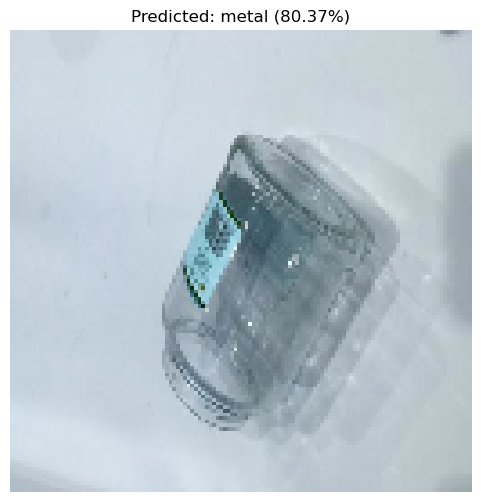

In [110]:
sample_image = X_test[1]  
result = ensemble_predict(sample_image, original_model=model, fine_tuned_model=fine_tuned_model, categories=CATEGORIES)

print("Prediction Results:")
print(f"Category: {result['category']}")
print(f"Confidence: {result['confidence']}%")
print(f"Recyclable Percentage: {result['recyclable_percentage']}%")
print(f"Non-Recyclable Percentage: {result['non_recyclable_percentage']}%")
print("Predicted Materials:")
for material, probability in result["predicted_materials"].items():
    print(f"{material}: {probability}%")

plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"Predicted: {result['category']} ({result['confidence']}%)")
plt.axis("off")
plt.show()


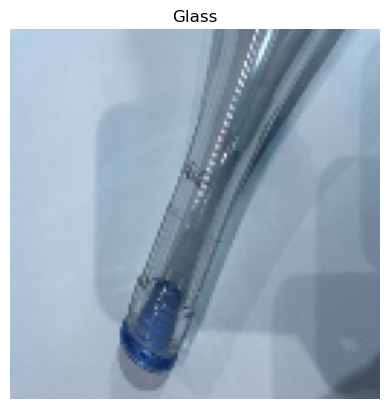

In [60]:
# Checking data labelled glass
# for i in range(len(y_train)):
for i in range(0,10):
    if y_train[i] == CATEGORIES.index('glass'): 
        plt.imshow(X_train[i])
        plt.title("Glass")
        plt.axis('off')
        plt.show()


In [90]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 [==============================] - 1s 67ms/step - loss: 1.1954 - accuracy: 0.5415
Test Accuracy: 54.15%


In [73]:
correct_predictions = 0
total_predictions = len(X_test)

for i in range(total_predictions):
    true_label = y_test[i]
    true_category = CATEGORIES[true_label]
    true_recyclable = true_category in recyclable

    image = X_test[i]
    result = ensemble_predict(image, model, glass_metal_model, CATEGORIES)

    predicted_recyclable = result["recyclable_percentage"] > result["non_recyclable_percentage"]

    if predicted_recyclable == true_recyclable:
        correct_predictions += 1

recyclability_accuracy = (correct_predictions / total_predictions) * 100
print(f"Recyclability Prediction Accuracy: {recyclability_accuracy:.2f}%")


1/1 [==============================] - 0s 21ms/step
Recyclability Prediction Accuracy: 95.26%


16/16 [==============================] - 1s 60ms/step


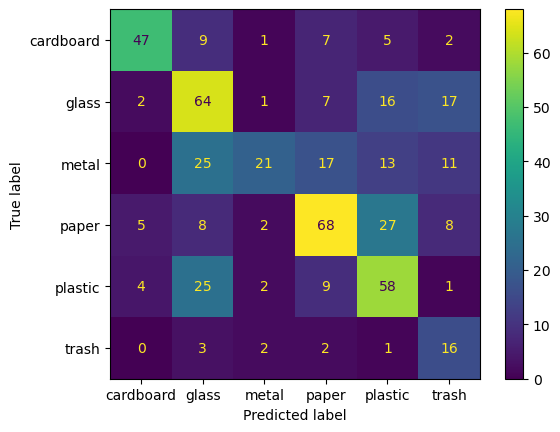

In [91]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test), axis=1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=CATEGORIES)


In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

layer_outputs = [layer.output for layer in model.layers[:5]]  # Adjust the number of layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

sample_image = X_test[0]  # Replace with an actual glass image from your test set
activations = activation_model.predict(sample_image[np.newaxis, ...])  # Add batch dimension

for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    plt.imshow(activation[0, :, :, 0], cmap='viridis')  # Show the first filter for each activation
    plt.title(f"Activation from Layer {i+1}")
    plt.axis('off')
    plt.show()
